<a href="https://colab.research.google.com/github/Narsi07/Landslide-susceptibility-prediction-using-AI-ML/blob/main/LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, confusion_matrix)
import joblib

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Dataset/1844Points.csv")

# Check missing values
print(data.isnull().sum())

# Check data types
print(data.dtypes)

# Check normalization (e.g., mean ~0, std ~1?)
print(data.describe())

# Check categorical encoding
print(data.head())
print("\n")

print(data.duplicated().sum())
print("\n")

data.info()

# Handle Outliers (using IQR method)
# Target column name (modify if needed)
target_col = 'target'

# Prepare list of columns to include (exclude problematic ones)a
numerical_cols = []
for col in data.columns:
    if col == target_col:
        continue
    if '/' in col or '==' in col:
        continue
    if data[col].dtype not in ['int64', 'float64']:
        continue
    if data[col].nunique() <= 10:  # likely binary or categorical
        continue
    numerical_cols.append(col)

# IQR-based capping only for valid numerical features
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

FID           0
X             0
Y             0
Aspect        0
DEM           0
DisToLinea    0
LineaDen      0
NDVI          0
Plan_Curva    0
Profile_Cu    0
Slope         0
Slope_Leng    0
STI           0
SPI           0
TPI           0
TWI           0
VRM           0
LULC_2015     0
habitat       0
GDP           0
DisFromRiv    0
DisFromRoa    0
target        0
dtype: int64
FID             int64
X             float64
Y             float64
Aspect        float64
DEM             int64
DisToLinea    float64
LineaDen      float64
NDVI          float64
Plan_Curva    float64
Profile_Cu    float64
Slope         float64
Slope_Leng    float64
STI           float64
SPI           float64
TPI           float64
TWI           float64
VRM           float64
LULC_2015       int64
habitat         int64
GDP             int64
DisFromRiv    float64
DisFromRoa    float64
target          int64
dtype: object
               FID            X            Y       Aspect          DEM  \
count  1844.000000  1844.

In [ ]:
# Create directories
os.makedirs('model_results', exist_ok=True)
os.makedirs('predictions', exist_ok=True)

# Load and prepare data
data = data.drop(['FID', 'X', 'Y'], axis=1)

# Train-test split
X = data.drop('target', axis=1)
y = data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 50, 'n_estimators': 50, 'num_leaves': 7}


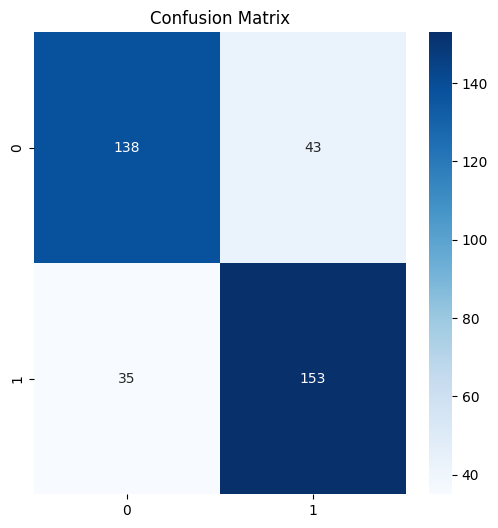

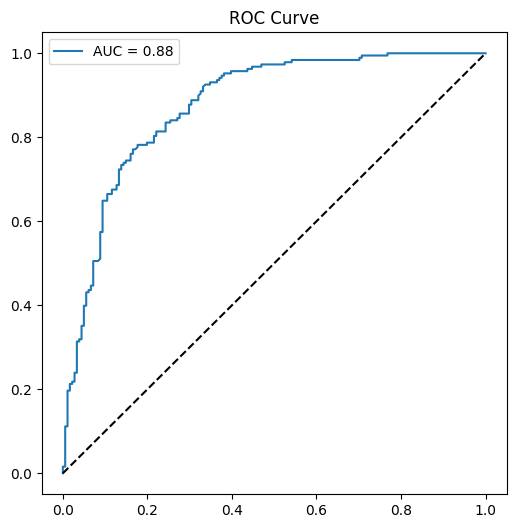

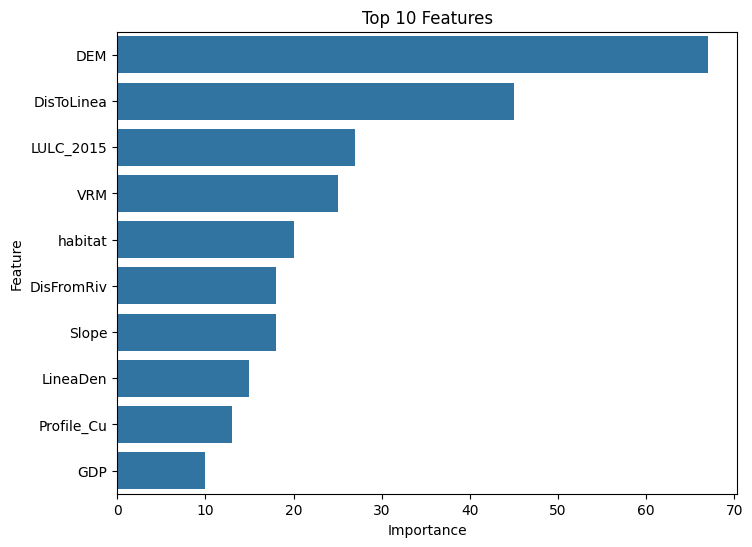

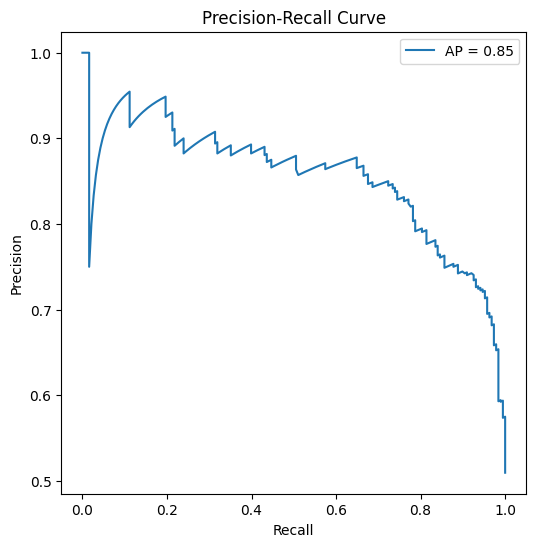


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       181
           1       0.78      0.81      0.80       188

    accuracy                           0.79       369
   macro avg       0.79      0.79      0.79       369
weighted avg       0.79      0.79      0.79       369


Accuracy: 0.7886
ROC AUC: 0.8767

Top 10 Features:
   Feature  Importance
       DEM          67
DisToLinea          45
 LULC_2015          27
       VRM          25
   habitat          20
DisFromRiv          18
     Slope          18
  LineaDen          15
Profile_Cu          13
       GDP          10


In [ ]:
#Lght GBM
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import joblib


# Define and train model with simpler parameters
params = {
    'n_estimators': [50, 100],          # Fewer boosting rounds
    'max_depth': [2, 3],                # Shallow trees
    'learning_rate': [0.01, 0.05],      # Slow learning
    'num_leaves': [7, 15],              # Small number of leaves
    'min_child_samples': [20, 50],      # Large leaf sizes
    'colsample_bytree': [0.6, 0.8]      # Subsample features
}

lgbm = LGBMClassifier(random_state=42, verbose=-1)
grid_search = GridSearchCV(lgbm, params, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]


pd.DataFrame({'true': y_val, 'pred': y_pred, 'probability': y_proba})\
      .to_csv('predictions/lgbm_predictions.csv', index=False)

# Save model
joblib.dump(best_model, 'model_results/lgbm_model.model')
print("Best Parameters:", grid_search.best_params_)

# Simple confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print("\n")
plt.close()

# Simple ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
auc_score = roc_auc_score(y_val, y_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend()
plt.show()
print("\n")
plt.close()

# Simple feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance.head(10))
plt.title('Top 10 Features')
plt.show()
print("\n")
plt.close()

#Precision Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, _ = precision_recall_curve(y_val, y_proba)
avg_precision = average_precision_score(y_val, y_proba)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print(f"\nAccuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"ROC AUC: {auc_score:.4f}")
print("\nTop 10 Features:")
print(importance.head(10).to_string(index=False))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import joblib
import os
import numpy as np

# Load the dataset containing feature and target data
data01 = pd.read_csv("/content/drive/MyDrive/Dataset/1844Points.csv", encoding='gbk')

data01 = data.drop(['FID', 'X', 'Y'], axis=1)

model_path = "/content/model_results/lgbm_model.model"

# Set a random seed for reproducibility
seed = 4

# Specify filenames for importing and exporting additional datasets
filename_import = "/content/drive/MyDrive/Dataset/TheLocationOfTheStudyArea.csv"
filename_export = "/content/predictions/TheLocation_light_model.csv"

# Load the dataset for the study area's locations and features
data_all = pd.read_csv(filename_import)

# Prepare the dataset for predictions
X_all = data_all.drop(['FID', 'X', 'Y'], axis=1)

# Save the column names for later use
header = data01.columns.tolist()

# Split the dataset into two dataframes based on the target value
data_0 = data01.loc[data01['target'] == 0]  # Data where target = 0
data_1 = data01.loc[data01['target'] == 1]  # Data where target = 1

# Split data where target = 0 into 80% training and 20% validation sets
data_0_X = data_0.drop(columns=["target"], axis=1)
data_0_Y = data_0.target
train_0_X, valid_0_X, train_0_y, valid_0_y = train_test_split(data_0_X, data_0_Y, test_size=0.2, random_state=seed)
save_TrainDate_0 = pd.DataFrame(np.column_stack([train_0_X, train_0_y]), columns=header)
save_ValidDate_0 = pd.DataFrame(np.column_stack([valid_0_X, valid_0_y]), columns=header)

# Split data where target = 1 into 80% training and 20% validation sets
data_1_X = data_1.drop(columns=["target"], axis=1)
data_1_Y = data_1.target
train_1_X, valid_1_X, train_1_y, valid_1_y = train_test_split(data_1_X, data_1_Y, test_size=0.2, random_state=seed)
save_TrainDate_1 = pd.DataFrame(np.column_stack([train_1_X, train_1_y]), columns=header)
save_ValidDate_1 = pd.DataFrame(np.column_stack([valid_1_X, valid_1_y]), columns=header)

# Combine the training datasets and shuffle
train_date = pd.concat([save_TrainDate_0, save_TrainDate_1])
train_date = train_date.sample(frac=1, random_state=42)

# Combine the validation datasets and shuffle
valid_date = pd.concat([save_ValidDate_0, save_ValidDate_1])
valid_date = valid_date.sample(frac=1, random_state=42)

# Separate features and target from training and validation datasets
train_y = train_date.target
train_X = train_date.drop(columns=["target"], axis=1)
valid_y = valid_date.target
valid_X = valid_date.drop(columns=["target"], axis=1)

# Load the pre-trained RandomForest model
lgbm_model = joblib.load(model_path)

# Evaluate the model on validation set
y_pred = lgbm_model.predict(valid_X)
y_proba = lgbm_model.predict_proba(valid_X)[:, 1]

# Print evaluation metrics
print("******* Evaluation Metrics *******")
print(f"Accuracy: {accuracy_score(valid_y, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(valid_y, y_proba):.3f}")

# Process data for prediction on the study area dataset
header = X_all.columns.tolist()
latitude_and_longitude = data_all.drop(columns=header, axis=1)
X_all = X_all.reindex(columns=train_X.columns)  # Align columns with training data
for column in X_all.columns:
    # Use mean from X_train if available, otherwise use X_all mean
    fill_value = train_X[column].mean() if column in train_X.columns else X_all[column].mean()
    X_all[column] = X_all[column].fillna(fill_value)

# Perform predictions using the pre-trained model
Y_all = lgbm_model.predict_proba(X_all)[:, 1]  # Predict probabilities for positive class

# Convert predictions to DataFrame
Y_all = pd.DataFrame(Y_all, columns=['target'])

# Merge everything together: coordinates + all original features + predictions
merge_XY = pd.concat([
    latitude_and_longitude,  # X, Y and any other non-feature columns
    data_all[header],       # All feature columns used for prediction
    Y_all                   # Predicted probabilities
], axis=1)

# Select specific columns to keep in final output (all features + prediction)
final_columns = [
    'FID', 'X', 'Y',        # Identifier and coordinates
    'Aspect', 'DEM',        # Topographic features
    'DisToLinea', 'LineaDen', 'NDVI',  # Distance and vegetation
    'Plan_Curva', 'Profile_Cu', 'Slope',  # Curvature and slope
    'Slope_Len', 'STI', 'SPI', 'TPI', 'TWI', 'VRM',  # Terrain indices
    'LULC_2015', 'habitat',   # Land use (note corrected from LULC_201)
    'GDP', 'DisFromRiv', 'DisFromRoa',  # Socio-economic
    'target'                # Prediction
]

# Ensure we only keep columns that actually exist in the data
final_columns = [col for col in final_columns if col in merge_XY.columns]

# Create final output with selected columns
final_output = merge_XY[final_columns]

# Save to CSV
final_output.to_csv(filename_export, index=False)

print("Merged predictions with all features successfully.")
print(final_output.columns.tolist())

******* Evaluation Metrics *******
Accuracy: 0.781
ROC AUC: 0.875
Merged predictions with all features successfully.
['FID', 'X', 'Y', 'Aspect', 'DEM', 'DisToLinea', 'LineaDen', 'NDVI', 'Plan_Curva', 'Profile_Cu', 'Slope', 'STI', 'SPI', 'TPI', 'TWI', 'VRM', 'LULC_2015', 'habitat', 'GDP', 'DisFromRiv', 'DisFromRoa', 'target']


In [ ]:
import pandas as pd
import joblib

# --- Load Data and Model ---
# Load your pre-generated predictions
predictions = pd.read_csv("/content/predictions/TheLocation_light_model.csv")  # Assuming columns: X, Y, target

# Load the trained model to get feature importance
model_path = "/content/model_results/lgbm_model.model"
lgbm_model = joblib.load(model_path)

# Get feature names from the model (assuming it's a RandomForest)
features = lgbm_model.feature_names_in_

# --- Feature Importance ---
# Get top 10 features from the model's built-in feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': lgbm_model.feature_importances_
}).sort_values('Importance', ascending=False)

top_10_features = feature_importance.head(10)['Feature'].tolist()

# Calculate feature ranges from predictions
feature_ranges = {}
for feature in top_10_features:
    if feature in predictions.columns:
        feature_ranges[feature] = (predictions[feature].min(), predictions[feature].max())

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# --- Interactive Prediction Function ---
def predict_landslide():
    print("\n=== Landslide Risk Predictor (Top 10 Features) ===")
    print("Enter the following features (press Enter after each):")

    # Get user input only for top 10 features
    input_values = {}
    for feature in top_10_features:
        while True:
            try:
                range_info = f" (range: {feature_ranges.get(feature, ('?', '?'))[0]:.2f}-{feature_ranges.get(feature, ('?', '?'))[1]:.2f})" if feature in feature_ranges else ""
                val = float(input(f"{feature}{range_info}: "))
                input_values[feature] = val
                break
            except ValueError:
                print("Please enter a valid number")

    # Find the closest match in the pre-generated predictions
    closest_match = None
    min_distance = float('inf')

    for _, row in predictions.iterrows():
        # Calculate a simple distance metric (could be improved)
        distance = sum(
            (input_values[feature] - row[feature])**2
            for feature in top_10_features
            if feature in row
        )

        if distance < min_distance:
            min_distance = distance
            closest_match = row

    # Show results
    if closest_match is not None:
        risk_level = "HIGH RISK" if closest_match['target'] >= 0.5 else "LOW RISK"
        print(f"\nPrediction: {risk_level}")
        print(f"Probability: {closest_match['target']:.1%}")
        print(f"Closest matching location: X={closest_match['X']}, Y={closest_match['Y']}")

        # Show top 3 features that contributed to this prediction
        print("\nMain contributing factors in this area:")
        top3 = feature_importance.head(3)
        for i, row in top3.iterrows():
            value = closest_match.get(row['Feature'], "unknown")
            print(f"- {row['Feature']} (value: {value}, importance: {row['Importance']:.3f})")
    else:
        print("\nNo matching location found in the pre-generated predictions")

# --- Run Interactive Prediction ---
while True:
    predict_landslide()
    if input("\nPredict another location? (y/n): ").lower() != 'y':
        break



Top 10 Most Important Features:
       Feature  Importance
1          DEM          67
2   DisToLinea          45
14   LULC_2015          27
13         VRM          25
15     habitat          20
17  DisFromRiv          18
7        Slope          18
3     LineaDen          15
6   Profile_Cu          13
16         GDP          10

=== Landslide Risk Predictor (Top 10 Features) ===
Enter the following features (press Enter after each):
DEM (range: 242.00-2588.00): 1034
DisToLinea (range: 0.00-3483.23): 2345
LULC_2015 (range: 0.00-8.00): 4
VRM (range: 0.00-0.18): 0.12
habitat (range: 100.00-1400.00): 1050
DisFromRiv (range: 0.00-10698.60): 7890
Slope (range: 0.00-78.07): 67
LineaDen (range: 0.00-0.77): 0.31
Profile_Cu (range: -0.02-0.03): 0.013
GDP (range: 59.00-323.00): 230

Prediction: LOW RISK
Probability: 10.0%
Closest matching location: X=109.939396, Y=31.548593

Main contributing factors in this area:
- DEM (value: 1601.0, importance: 67.000)
- DisToLinea (value: 2200.449951, importan